<a href="https://colab.research.google.com/github/JinzhiT/5750-project-2/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment


X, y_true = make_blobs(n_samples=1000, centers=5, n_features=10,
                       cluster_std=1.5, random_state=1)
X = StandardScaler().fit_transform(X)

k = 5
kmeans = KMeans(n_clusters=k, n_init=20, random_state=1).fit(X)
labels_pred = kmeans.labels_
print("Smallest inertia (k=5):", round(kmeans.inertia_, 3))  # ~924.316

cm_raw = confusion_matrix(y_true, labels_pred, labels=np.arange(k))
row_ind, col_ind = linear_sum_assignment(-cm_raw)     # maximize correct
mapping = {pred: true for true, pred in zip(row_ind, col_ind)}
labels_matched = np.vectorize(lambda c: mapping[c])(labels_pred)
cm_matched = confusion_matrix(y_true, labels_matched, labels=np.arange(k))
print("Matched accuracy:", np.trace(cm_matched) / np.sum(cm_matched))

pca = PCA(n_components=2, random_state=1).fit(X)
X_2d = pca.transform(X)
centers_2d = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_pred, s=10)
plt.scatter(centers_2d[:,0], centers_2d[:,1], marker="X", s=200,
            linewidths=1, edgecolors="black")
plt.title("K-means (k=5) on Gaussian Blobs — PCA 2D view")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.savefig("pca_clusters_centers.png", dpi=200); plt.close()

k_values = list(range(1, 8))
inertias = []
for kk in k_values:
    km = KMeans(n_clusters=kk, n_init=3, random_state=1).fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Analysis (k vs. inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.xticks(k_values)
plt.tight_layout(); plt.savefig("elbow_plot.png", dpi=200); plt.close()

plt.figure(figsize=(6,5))
plt.imshow(cm_matched, aspect="auto"); plt.colorbar()
plt.title("Confusion Matrix (true vs. matched predicted labels)")
plt.xlabel("Predicted (matched)"); plt.ylabel("True")
plt.xticks(ticks=np.arange(k), labels=[str(i) for i in range(k)])
plt.yticks(ticks=np.arange(k), labels=[str(i) for i in range(k)])
plt.tight_layout(); plt.savefig("confusion_matrix_matched.png", dpi=200); plt.close()


Smallest inertia (k=5): 924.316
Matched accuracy: 1.0


# 2. Clustering Fashion-MNIST using $k$-means

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


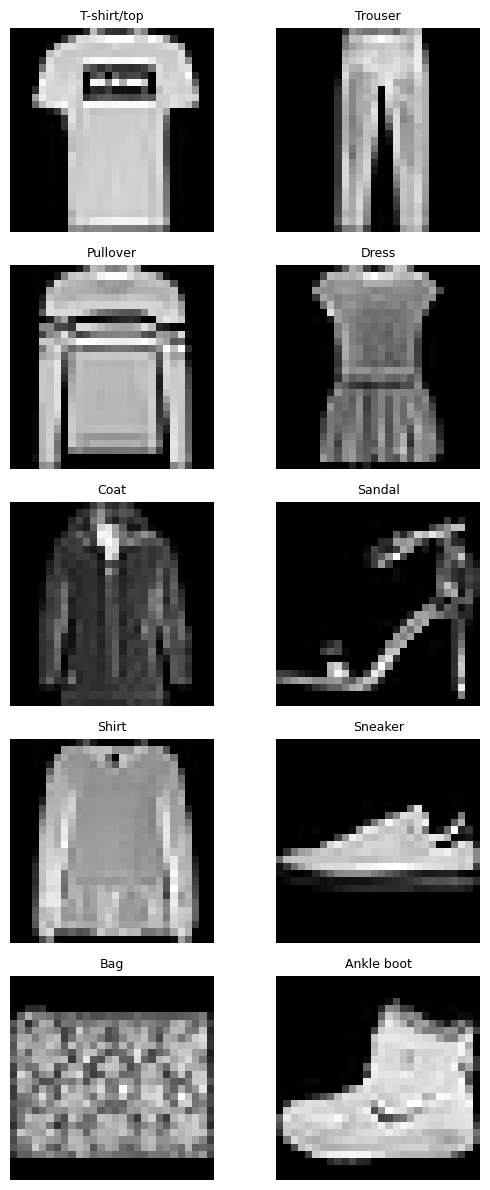

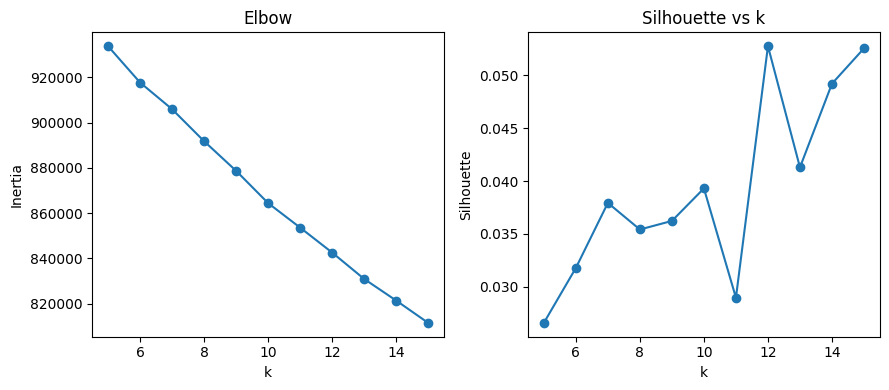

Adjusted Rand Index (ARI): 0.3537
Normalized Mutual Info (NMI): 0.5358
Greedy matching accuracy (for interpretation only): 0.5588


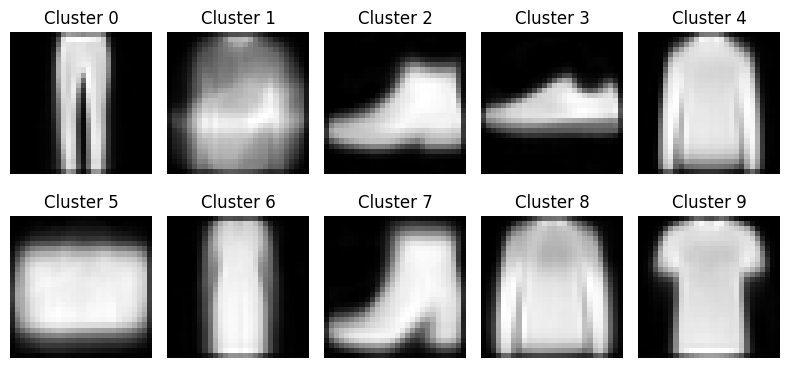

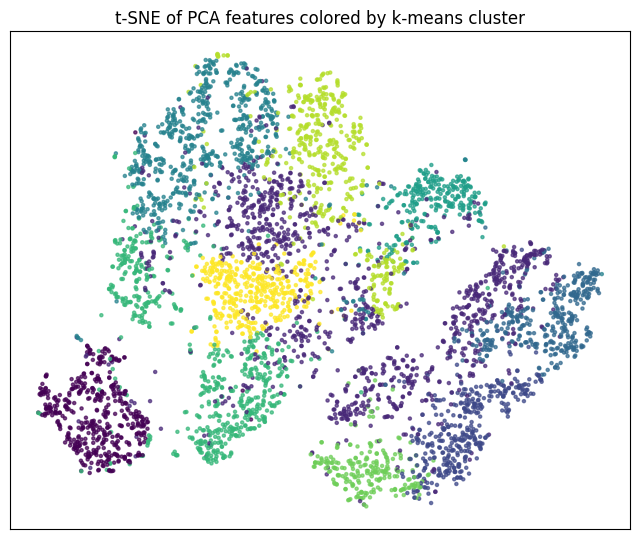

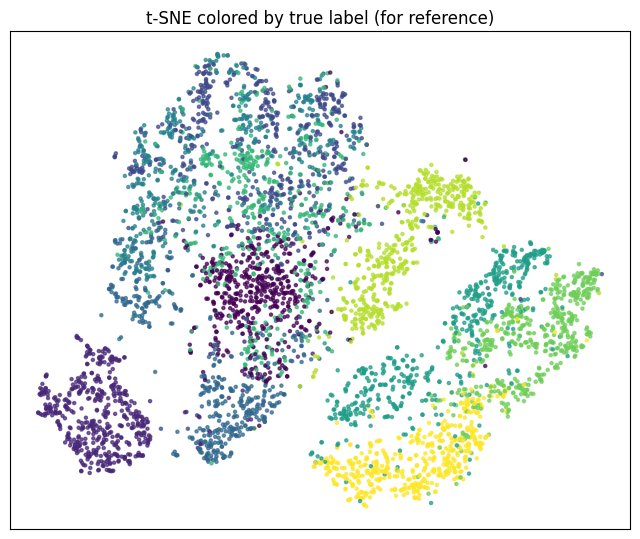

In [1]:

# Fashion-MNIST: K-means
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from scipy.optimize import linear_sum_assignment


# Classes (0–9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)                    # strings -> ints
n_samples, n_features = X.shape      # (70000, 784)

# -------------------------
# 1) Quick look: 5×2 grid with distinct classes
# -------------------------
label_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

# pick the first occurrence for each class
idx_first = [np.where(y == c)[0][0] for c in range(10)]
imgs = X[idx_first].reshape(-1, 28, 28)

fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for ax, img, lab in zip(axes.ravel(), imgs, label_names):
    ax.imshow(img, cmap="gray")
    ax.set_title(lab, fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.savefig("fig_samples_5x2.png", dpi=200)
plt.show()

# -------------------------
# 2) Subsample + scale + PCA

rng = np.random.default_rng(42)
n_keep = 20000
keep_idx = np.hstack([rng.choice(np.where(y==c)[0], n_keep//10, replace=False) for c in range(10)])
rng.shuffle(keep_idx)

X_sub = X[keep_idx].astype(np.float32) / 255.0   # put pixels on [0,1]
y_sub = y[keep_idx]

# PCA to 50 dims (whitened helps k-means)
pca = PCA(n_components=50, whiten=True, random_state=42, svd_solver="randomized")
Z = pca.fit_transform(X_sub)                      # shape: (n_keep, 50)

# Optional centering/standardization (PCA with whiten=True already standardizes components)

# -------------------------
# 3) Choose K

inertias, sils, ks = [], [], list(range(5, 16))
for k in ks:
    km_tmp = KMeans(n_clusters=k, n_init=20, random_state=42)
    lbl = km_tmp.fit_predict(Z)
    inertias.append(km_tmp.inertia_)
    # Silhouette on a (smaller) slice for speed
    sample_slice = slice(0, min(5000, Z.shape[0]))
    sils.append(silhouette_score(Z[sample_slice], lbl[sample_slice], metric="euclidean"))

fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow")
plt.subplot(1,2,2)
plt.plot(ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette vs k")
plt.tight_layout()
plt.savefig("fig_k_selection.png", dpi=200)
plt.show()

# -------------------------
# 4) Final k-means (k=10)

k = 10
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
cluster_pred = kmeans.fit_predict(Z)

# -------------------------
# 5) Evaluation vs. labels (unsupervised metrics)

ari = adjusted_rand_score(y_sub, cluster_pred)
nmi = normalized_mutual_info_score(y_sub, cluster_pred)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")

# Map clusters -> labels via Hungarian assignment (for a readable confusion)
conf = np.zeros((k, 10), dtype=int)
for c_id, lab in zip(cluster_pred, y_sub):
    conf[c_id, lab] += 1
row_ind, col_ind = linear_sum_assignment(conf.max() - conf)  # maximize matches

acc = conf[row_ind, col_ind].sum() / conf.sum()
print(f"Greedy matching accuracy (for interpretation only): {acc:.4f}")

# -------------------------
# 6) Visualize cluster centers

centers_pca = kmeans.cluster_centers_
centers_pix = pca.inverse_transform(centers_pca)
centers_pix = np.clip(centers_pix, 0, None)

fig, axes = plt.subplots(2, 5, figsize=(8, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(centers_pix[i].reshape(28,28), cmap="gray")
    ax.set_title(f"Cluster {i}")
    ax.axis("off")
plt.tight_layout()
plt.savefig("fig_cluster_centers.png", dpi=200)
plt.show()

# -------------------------
# 7) 2-D visualization (t-SNE) of clusters (optional; slow ~1–2 min on 20k)

try:
    from sklearn.manifold import TSNE
    sel = rng.choice(np.arange(Z.shape[0]), size=min(5000, Z.shape[0]), replace=False)
    Z2 = TSNE(n_components=2, init="pca", learning_rate="auto", random_state=42, perplexity=30).fit_transform(Z[sel])
    cp = cluster_pred[sel]
    yl = y_sub[sel]

    plt.figure(figsize=(6.5,5.5))
    plt.scatter(Z2[:,0], Z2[:,1], c=cp, s=5, alpha=0.7)
    plt.title("t-SNE of PCA features colored by k-means cluster")
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig("fig_tsne_clusters.png", dpi=200)
    plt.show()

    plt.figure(figsize=(6.5,5.5))
    plt.scatter(Z2[:,0], Z2[:,1], c=yl, s=5, alpha=0.7)
    plt.title("t-SNE colored by true label (for reference)")
    plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig("fig_tsne_labels.png", dpi=200)
    plt.show()
except Exception as e:
    print("t-SNE skipped:", e)


# 3. Dimensionality reduction for Fashion-MNIST

PCA  k=10   corr=0.8919
PCA  k=20   corr=0.9442
PCA  k=50   corr=0.9831
PCA  k=100  corr=0.9939
PCA  k=200  corr=0.9982
RP   k=10   corr=0.8095
RP   k=20   corr=0.8825
RP   k=50   corr=0.9536
RP   k=100  corr=0.9752
RP   k=200  corr=0.9846

Saved table: /content/export/dr_correlations.csv


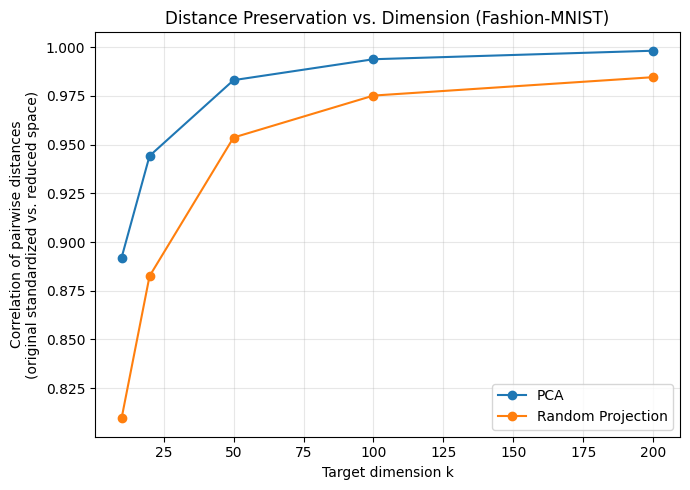

In [8]:
# ==== Fashion-MNIST: PCA vs Random Projection (JL) ====

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

# --------------------- config ---------------------
EXPORT_DIR = Path("export")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

K_LIST = [10, 20, 50, 100, 200]
N_KEEP = 10000
N_PAIRS = 150_000
RNG = np.random.default_rng(42)

# --------------------- load & standardize ---------------------

X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

per_class = N_KEEP // 10
keep_idx = np.hstack([RNG.choice(np.where(y == c)[0], per_class, replace=False) for c in range(10)])
RNG.shuffle(keep_idx)

X = X[keep_idx].astype(np.float32)
y_keep = y[keep_idx]  # not strictly needed here


scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(X)


n = X_std.shape[0]
i_idx = RNG.integers(0, n, size=N_PAIRS, endpoint=False)
j_idx = RNG.integers(0, n, size=N_PAIRS, endpoint=False)
mask = i_idx != j_idx
i_idx, j_idx = i_idx[mask], j_idx[mask]

def pairwise_dists_for_pairs(A, I, J):
    """Euclidean distances for selected index pairs without building full distance matrix."""
    diffs = A[I] - A[J]
    return np.sqrt(np.einsum('ij,ij->i', diffs, diffs))


d0 = pairwise_dists_for_pairs(X_std, i_idx, j_idx)


def corr(a, b):
    # Pearson correlation
    a = (a - a.mean()) / (a.std() + 1e-12)
    b = (b - b.mean()) / (b.std() + 1e-12)
    return float(np.mean(a * b))

results = []

# PCA
for k in K_LIST:
    pca = PCA(n_components=k, svd_solver="randomized", random_state=42)
    Zp = pca.fit_transform(X_std)
    dp = pairwise_dists_for_pairs(Zp, i_idx, j_idx)
    c = corr(d0, dp)
    results.append(("PCA", k, c))
    print(f"PCA  k={k:<3d}  corr={c:.4f}")

# Gaussian Random Projection
for k in K_LIST:
    rp = GaussianRandomProjection(n_components=k, random_state=42)
    Zr = rp.fit_transform(X_std)
    dr = pairwise_dists_for_pairs(Zr, i_idx, j_idx)
    c = corr(d0, dr)
    results.append(("RP", k, c))
    print(f"RP   k={k:<3d}  corr={c:.4f}")

# --------------------- save CSV table ---------------------
import csv
csv_path = EXPORT_DIR / "dr_correlations.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["method", "k", "corr_with_original_distances"])
    for m, k, c in results:
        w.writerow([m, k, f"{c:.6f}"])
print(f"\nSaved table: {csv_path.resolve()}")

# --------------------- make and save plot ---------------------
# Collect back into arrays for plotting
ks = np.array(K_LIST)
pca_corr = np.array([r[2] for r in results if r[0] == "PCA"])
rp_corr  = np.array([r[2] for r in results if r[0] == "RP"])

plt.figure(figsize=(7,5))
plt.plot(ks, pca_corr, marker="o", label="PCA")
plt.plot(ks, rp_corr,  marker="o", label="Random Projection")
plt.xlabel("Target dimension k")
plt.ylabel("Correlation of pairwise distances\n(original standardized vs. reduced space)")
plt.title("Distance Preservation vs. Dimension (Fashion-MNIST)")
plt.grid(True, alpha=0.3)
plt.legend()
plot_path = EXPORT_DIR / "fig_dr_corr_vs_k.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()



# 4. Clustering Fashion-MNIST using spectral clustering

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

#config
EXPORT = Path("export"); EXPORT.mkdir(exist_ok=True, parents=True)

N_KEEP = 4000                # Spectral doesn't scale well; keep this modest (2k–5k recommended)
PCA_DIMS = 50                # work in PCA space
N_NEIGHBORS = 15             # k-NN graph for spectral affinity
RNG = np.random.default_rng(42)
LABELS = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
          "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

#load & stratified subsample
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)
per_class = N_KEEP // 10
idx = np.hstack([RNG.choice(np.where(y==c)[0], per_class, replace=False) for c in range(10)])
RNG.shuffle(idx)
X = X[idx].astype(np.float32) / 255.0
y = y[idx]

#standardize + PCA
X_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
pca = PCA(n_components=PCA_DIMS, whiten=True, random_state=42, svd_solver="randomized")
Z = pca.fit_transform(X_std)

#spectral clustering
spec = SpectralClustering(
    n_clusters=10,
    eigen_solver=None,
    affinity="nearest_neighbors",
    n_neighbors=N_NEIGHBORS,
    assign_labels="kmeans",
    random_state=42,
    n_init=10
)
spec_labels = spec.fit_predict(Z)

#metrics (ARI/NMI) + matched accuracy
def matched_accuracy(pred, true, n_cls=10):
    conf = np.zeros((n_cls, n_cls), dtype=int)
    for p,t in zip(pred,true): conf[p, t] += 1
    r, c = linear_sum_assignment(conf.max() - conf)  # maximize
    return conf[r, c].sum()/conf.sum(), conf, r, c

ari_spec = adjusted_rand_score(y, spec_labels)
nmi_spec = normalized_mutual_info_score(y, spec_labels)
acc_spec, conf_spec, r_idx, c_idx = matched_accuracy(spec_labels, y, 10)

print(f"[Spectral] ARI={ari_spec:.4f}  NMI={nmi_spec:.4f}  matched-acc={acc_spec:.4f}")

#comparison: k-means on same features
kmeans = KMeans(n_clusters=10, n_init=50, random_state=42)
km_labels = kmeans.fit_predict(Z)
ari_km = adjusted_rand_score(y, km_labels)
nmi_km = normalized_mutual_info_score(y, km_labels)
acc_km, conf_km, _, _ = matched_accuracy(km_labels, y, 10)
print(f"[K-means ] ARI={ari_km:.4f}  NMI={nmi_km:.4f}  matched-acc={acc_km:.4f}")

#figure 1: medoid exemplars per spectral cluster (2x5)
medoid_idx = []
for c in range(10):
    inds = np.where(spec_labels==c)[0]
    centroid = Z[inds].mean(axis=0, keepdims=True)
    d2 = np.sum((Z[inds]-centroid)**2, axis=1)
    medoid_idx.append(inds[np.argmin(d2)])

imgs = X[medoid_idx].reshape(-1,28,28)
fig, axes = plt.subplots(2,5, figsize=(8,4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(imgs[i], cmap="gray")
    ax.set_title(f"Cluster {i}", fontsize=9)
    ax.axis("off")
plt.tight_layout()
p1 = EXPORT/"fig_spectral_medoids.png"
fig.savefig(p1, dpi=300); plt.close(fig)

#figure 2: confusion heatmap (spectral vs true)
fig = plt.figure(figsize=(6.5,5.5))
plt.imshow(conf_spec, interpolation="nearest")
plt.colorbar(label="count")
plt.xticks(range(10), LABELS, rotation=45, ha='right', fontsize=8)
plt.yticks(range(10), [f"C{i}" for i in range(10)], fontsize=8)
plt.xlabel("True label"); plt.ylabel("Spectral cluster")
plt.title("Spectral Clustering Confusion (counts)")
plt.tight_layout()
p2 = EXPORT/"fig_spectral_confusion.png"
plt.savefig(p2, dpi=300); plt.close(fig)

#figure 3: t-SNE of PCA features, colored by spectral cluster
try:
    from sklearn.manifold import TSNE
    sel = RNG.choice(np.arange(Z.shape[0]), size=min(2500, Z.shape[0]), replace=False)
    Z2 = TSNE(n_components=2, init="pca", learning_rate="auto",
              perplexity=30, random_state=42).fit_transform(Z[sel])
    lab = spec_labels[sel]

    plt.figure(figsize=(6.5,5.5))
    plt.scatter(Z2[:,0], Z2[:,1], c=lab, s=5, alpha=0.8)
    plt.xticks([]); plt.yticks([])
    plt.title("t-SNE of PCA features — colored by Spectral cluster")
    plt.tight_layout()
    p3 = EXPORT/"fig_spectral_tsne.png"
    plt.savefig(p3, dpi=300); plt.close()
except Exception as e:
    print("[info] t-SNE skipped:", e)
    p3 = None

# figure 4: bar chart of ARI/NMI — Spectral vs K-means
labels = ["ARI","NMI","Matched-Acc"]
spec_vals = [ari_spec, nmi_spec, acc_spec]
km_vals   = [ari_km,   nmi_km,   acc_km]
x = np.arange(len(labels)); w = 0.38

plt.figure(figsize=(6.8,4.2))
plt.bar(x - w/2, spec_vals, width=w, label="Spectral")
plt.bar(x + w/2, km_vals,   width=w, label="K-means")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Spectral vs K-means (same PCA(50) features)")
plt.legend()
plt.tight_layout()
p4 = EXPORT/"fig_spectral_vs_kmeans_metrics.png"
plt.savefig(p4, dpi=300); plt.close()




[Spectral] ARI=0.3197  NMI=0.5692  matched-acc=0.4835
[K-means ] ARI=0.3446  NMI=0.5268  matched-acc=0.4895
